In [1]:
%matplotlib inline
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

In [2]:
import ndreg
from ndreg import preprocessor, registerer, util
import SimpleITK as sitk
import numpy as np
from skimage.external import tifffile

In [3]:
def myshow(img, cmap='gray', colorbar=False):
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=cmap)
    if colorbar: plt.colorbar()
    plt.axis('off')
    plt.show()

In [4]:
def normalize(img, percentile=0.99):
    max_val = ndreg.imgPercentile(img, percentile)
    return sitk.Clamp(img, upperBound=max_val) / max_val

In [5]:
def plot(img1, img2, title1="", title2="", blend=0.2):
    
    
    height, width = img1.shape
    overlap = np.zeros((height, width))
    for a in range(height):
        for b in range(width):
            grey = img1[a,b]*blend + img2[a,b]*blend
            overlap[a,b] = grey

    x_errors = []
    for j in range(width):
        error = np.sqrt(np.sum(np.square(img1[:,j] - img2[:,j])))
        x_errors.append(error)
    x_errors = np.log(np.array(x_errors))

#     print(x_errors)
    
    y_errors = []
    for i in range(height):
        error = np.sqrt(np.sum(np.square(img1[i,:] - img2[i,:])))
        y_errors.append(error)
    y_errors = np.log(np.array(y_errors))
    
#     print(y_errors)
        
    plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(5, 12, wspace=0.5, hspace=1)
    
    ax1 = plt.subplot(gs[:4, 0])
    ax2 = plt.subplot(gs[:4, 2:6])
    ax3 = plt.subplot(gs[4, 2:6])
    ax4 = plt.subplot(gs[:4, 7:])

    ax1.plot(y_errors, range(height))
    ax1.invert_yaxis()
    ax1.set_xlabel('Log MSE',fontsize=11)
    ax1.set_ylabel('Row pixel', fontsize=11)

    ax3.plot(range(width), x_errors)
    ax3.set_xlabel('Column pixel',fontsize=11)
    ax3.set_ylabel('Log MSE', fontsize=11)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()

    ax2.imshow(overlap, aspect='auto')
    ax2.grid(True)
    ax2.set_title(title1)

    
    difference_image = (normalize(sitk.GetImageFromArray(img2)) - normalize(sitk.GetImageFromArray(img1)))**2
    cax = ax4.imshow(sitk.GetArrayViewFromImage(difference_image), cmap='gray')
#     ax4.axis('off')
    ax4.set_title(title2)
    cbar = plt.colorbar(cax)
    
    plt.show()

In [6]:
tp1 = tifffile.imread('./data/R04_tp1.tif')
tp1 = np.clip(tp1, -3000, 12000)
tp2 = tifffile.imread('./data/R04_tp2.tif')
tp2 = np.clip(tp2, -3000, 12000)

tp1_slice0 = tp1[0]
tp2_slice0 = tp2[0]

In [8]:
# tp1 = util.imgRead('./data/R04_tp1.tif')
# tp2 = util.imgRead('./data/R04_tp2.tif')

plt.imshow(sitk.GetArrayViewFromImage(tp1[:,:,0]), cmap='gray')
plt.subplot(121)
plt.imshow(sitk.GetArrayViewFromImage(normalize(tp1[:,:,0], percentile=0.99)), cmap='gray')
plt.subplot(122)
plt.imshow(sitk.GetArrayViewFromImage(normalize(tp2[:,:,0], percentile=0.99)), cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'GetPixelIDValue'

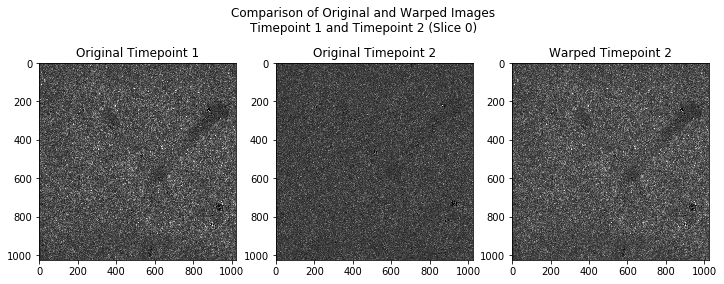

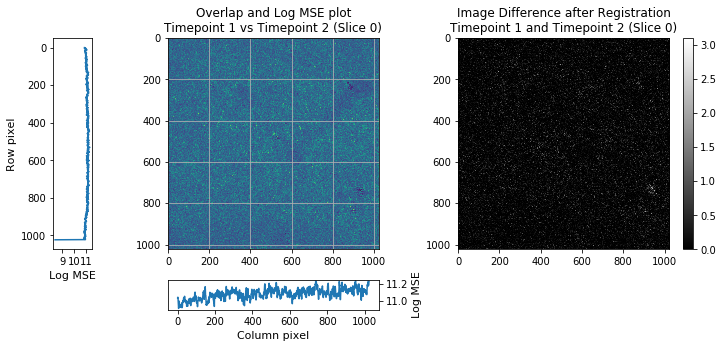

Slice 0: Registration error is: 0.121120085742 voxels^2


In [9]:
depth = max(tp1.shape[0], tp2.shape[0])

for i in range(1):
    tp1_slice = sitk.GetImageFromArray(tp1[i])
    tp2_slice = sitk.GetImageFromArray(tp2[i])
    
    final_transform = registerer.register_affine(tp1_slice, tp2_slice)
    corrected_img = registerer.resample(tp1_slice, final_transform, tp2_slice)
#     difference_image = (normalize(tp2_slice) - normalize(tp1_slice))**2
#     myshow(difference_image,colorbar=True)
    plt.figure(figsize=(12,4.5))
    plt.suptitle("Comparison of Original and Warped Images\nTimepoint 1 and Timepoint 2 (Slice 0)")
    plt.subplot(131)
    plt.title('Original Timepoint 1')
    plt.imshow(sitk.GetArrayViewFromImage(tp1_slice), cmap='gray')
    plt.subplot(132)
    plt.title('Original Timepoint 2')
    plt.imshow(sitk.GetArrayViewFromImage(tp2_slice), cmap='gray')
    plt.subplot(133)
    plt.title('Warped Timepoint 2')
    plt.imshow(sitk.GetArrayViewFromImage(corrected_img), cmap='gray')
    plt.show()
    
    plot(sitk.GetArrayViewFromImage(tp2_slice), sitk.GetArrayViewFromImage(tp1_slice), "Overlap and Log MSE plot\nTimepoint 1 vs Timepoint 2 (Slice {})".format(i), "Image Difference after Registration\nTimepoint 1 and Timepoint 2 (Slice {})".format(i))

    print("Slice {}: Registration error is: {} voxels^2".format(i, registerer.imgMSE(normalize(tp1_slice), normalize(tp2_slice))))

In [10]:
# depth = max(sitk.GetArrayViewFromImage(tp1).shape[0], sitk.GetArrayViewFromImage(tp2).shape[0])

# for i in range(1):
#     tp1_slice = tp1[:,:,i]
#     tp2_slice = tp2[:,:,i]
    
#     plt.subplot(121)
#     plt.imshow(sitk.GetArrayViewFromImage(tp2_slice), cmap='gray')
#     plt.subplot(122)
#     plt.imshow(sitk.GetArrayViewFromImage(tp1_slice), cmap='gray')
#     plt.show()
    
    
#     final_transform = registerer.register_affine(tp1_slice, tp2_slice)
#     corrected_img = registerer.resample(tp1_slice, final_transform, tp2_slice)
# #     difference_image = (normalize(tp2_slice) - normalize(tp1_slice))**2
# #     myshow(difference_image,colorbar=True)
#     plt.subplot(121)
#     plt.imshow(sitk.GetArrayViewFromImage(tp2_slice), cmap='gray')
#     plt.subplot(122)
#     plt.imshow(sitk.GetArrayViewFromImage(tp1_slice), cmap='gray')
#     plt.show()
    
#     plot(sitk.GetArrayViewFromImage(tp2_slice), sitk.GetArrayViewFromImage(tp1_slice), "Overlap and Log MSE plot\nTimepoint 1 vs Timepoint 2 (Slice {})".format(i), "Image Difference after Registration\nTimepoint 1 and Timepoint 2 (Slice {})".format(i))

#     print("Slice {}: Registration error is: {} voxels^2".format(i, registerer.imgMSE(normalize(tp1_slice), normalize(tp2_slice))))

In [11]:
tp1 = tifffile.imread('./data/R04_tp1.tif')
tp1 = np.clip(tp1, -3000, 12000)#.astype(np.uint16)
tp2 = tifffile.imread('./data/R04_tp2.tif')
tp2 = np.clip(tp2, -3000, 12000)#.astype(np.uint16)

tp1_slice0 = tp1[0]
# plt.imshow(tp1_slice0, cmap='gray', vmin=-3000, vmax=12000)

tp2_slice0 = tp2[0]
# plt.imshow(tp2_slice0, cmap='gray', vmin=-3000, vmax=12000)
# print(np.unique(tp1_slice0))
# plt.hist(tp2_slice0.ravel(), bins=256, range=(-3000, 12000), fc='k', ec='k')

tp1 = sitk.GetImageFromArray(tp1)
tp2 = sitk.GetImageFromArray(tp2)

In [ ]:
final_transform = registerer.register_rigid(tp1, tp2)
corrected_img = registerer.resample(tp1, final_transform, tp2)

plt.figure(figsize=(12,4.5))
plt.suptitle("Comparison of Original and Warped Images\nTimepoint 1 and Timepoint 2 (Slice 0)")
plt.subplot(131)
plt.title('Original Timepoint 1')
plt.imshow(sitk.GetArrayViewFromImage(tp1[0]), cmap='gray')
plt.subplot(132)
plt.title('Original Timepoint 2')
plt.imshow(sitk.GetArrayViewFromImage(tp2[0]), cmap='gray')
plt.subplot(133)
plt.title('Warped Timepoint 2')
plt.imshow(sitk.GetArrayViewFromImage(corrected_img), cmap='gray')
plt.show()

# plot(sitk.GetArrayViewFromImage(tp2_slice), sitk.GetArrayViewFromImage(tp1_slice), "Overlap and Log MSE plot\nTimepoint 1 vs Timepoint 2 (Slice {})".format(i), "Image Difference after Registration\nTimepoint 1 and Timepoint 2 (Slice {})".format(i))

# print("Slice {}: Registration error is: {} voxels^2".format(i, registerer.imgMSE(normalize(tp1_slice), normalize(tp2_slice))))